In [1]:
!pip install -r /home/onyxia/work/python_ensae/requirements.txt --quiet > /dev/null 2>&1

import pandas as pd
import numpy as np
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile
import matplotlib.pyplot as plt

#Imports pour l'ACP
from sklearn.preprocessing import MinMaxScaler #pour normaliser entre 0 et 1
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm

#Imports pour la modélisation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [2]:
url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# I - Statistiques descriptives

Dans cette section, nous examinerons le comportement de la variable ACTEU, qui indique le statut d'activité de l'individu selon les critères du BIT. 

Sont considérées comme étant en emploi toutes les personnes âgées de plus de 15 ans ayant travaillé de manière non bénévole au cours de la semaine de référence. Les personnes ayant un emploi mais ne l'exerçant pas pour diverses raisons, telles qu'un congé maternité, paternité ou une maladie, font également partie de cette catégorie.

Sont considérées comme étant au chômage, conformément à la définition du Bureau International du Travail (BIT) toutes les personnes de moins de 75 ans qui n'ont pas d'emploi, qui sont disponibles pour travailler dans les quinze jours à venir, et qui ont entrepris des démarches actives de recherche d'emploi au cours des quatre dernières semaines ou qui commenceront un nouvel emploi dans moins de trois mois.

## A - Statut d'activité

In [ ]:
#Catégories possibles
categories = ["Actif occupé", "Chômeur", "Inactif"]
value = [1,2,3] #on a aussi des NA mais ils ne sont pas pondérés
N=EEC_2019["EXTRIAN"].sum()

#Effectif par catégorie
result_dict = {"ACTEU": categories, 'Effectif': [], 'Proportion':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond = EEC_2019[EEC_2019["ACTEU"]==val]["EXTRIAN"].sum()
    result_dict['Effectif'].append(round(somme_pond,0))
    result_dict['Proportion'].append(round(somme_pond/N,3))
data = pd.DataFrame(result_dict).sort_values(by="ACTEU").reset_index(drop=True)
data

In [ ]:
#Calcul du taux de chômage selon les critères du BIT
Effectif_chom = data.loc[data["ACTEU"] == "Chômeur"]["Effectif"][1]
Effectif_popactive = data.loc[data["ACTEU"].isin(["Chômeur", "Actif occupé"])]["Effectif"].sum()

print(f"Le taux de chômage en France selon le BIT en 2019 est de {round(100*Effectif_chom/Effectif_popactive,1)}%")

## B - Durée du chômage

In [ ]:
#répartiton de la durée de chômage avec la variable ANCCHOM (on pondère par EXTRIAN)
EEC_chom_2019=EEC_2019[EEC_2019["ACTEU"]==2]
EEC_chom_2020=EEC_2020[EEC_2020["ACTEU"]==2]
EEC_chom_2019["ANCCHOM"].describe()

In [ ]:
plt.hist([EEC_chom_2019["ANCCHOM"],EEC_chom_2020["ANCCHOM"]],bins=[i - 0.5 for i in range(1, 10)], weights = [EEC_chom_2019["EXTRIAN"],EEC_chom_2020["EXTRIAN"]], align='mid',width=0.4, density=True,label=["2019","2020"])
plt.title('Histogramme de la durée du chômage')
plt.xticks(range(1,10), ["< 1 mo","1< <3mo","3< <6mo","6< <12 mo","12< <18 mo","18 mo< <2 y","2< <3 y",">3 y",""], rotation=45, ha="right")
plt.xlabel('Durée du chômage')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

On a une répartition qui s'apparente à une loi normale centré sur 6 mois. En effet, l'augmentation que l'on observe pour "entre 2 et 3 ans" et "3 ans et plus" est due au fait que ses entrées correspondent à des intervalles plus longs. 

## C- CSP

On s'intéresse maintenant au statut d'activité et à la catégorie socioprofessionnelle, qui est indiquée uniquement pour la population active. 

In [7]:
#Catégories possibles
categories = ["Non-renseigné", "Agriculteurs", "Artisans, commerçants, chefs d'entreprise", "Cadres et professions intellectuelles supérieures", "Professions intermédiaires", "Employés", "Ouvriers", "Inactifs ayant déjà eu une activité pro", "Chômeurs et inactifs n'ayant jamais travaillé", "NA"]
value = EEC_2019["CSTOTR"].unique()

#tableau avec CSTOR/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"CSTOTR": value, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CSTOTR"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CSTOTR"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C+somme_pond_E),2))
data = pd.DataFrame(result_dict).sort_values(by="CSTOTR").reset_index(drop=True)
data

/tmp/ipykernel_29327/1983034584.py:12: RuntimeWarning: invalid value encountered in scalar divide
  result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C+somme_pond_E),2))


,CSTOTR,Effectif_emploi,Effectif_chom,Proportion_chom
0,0.0,120715.0,12660.0,0.09
1,1.0,403572.0,4811.0,0.01
2,2.0,1825004.0,75003.0,0.04
3,3.0,5240635.0,191348.0,0.04
4,4.0,6957339.0,345401.0,0.05
5,5.0,7291505.0,737501.0,0.09
6,6.0,5337259.0,752857.0,0.12
7,7.0,0.0,0.0,NaN
8,8.0,0.0,386600.0,1.00
9,NaN,0.0,0.0,NaN


posx and posy should be finite values
posx and posy should be finite values


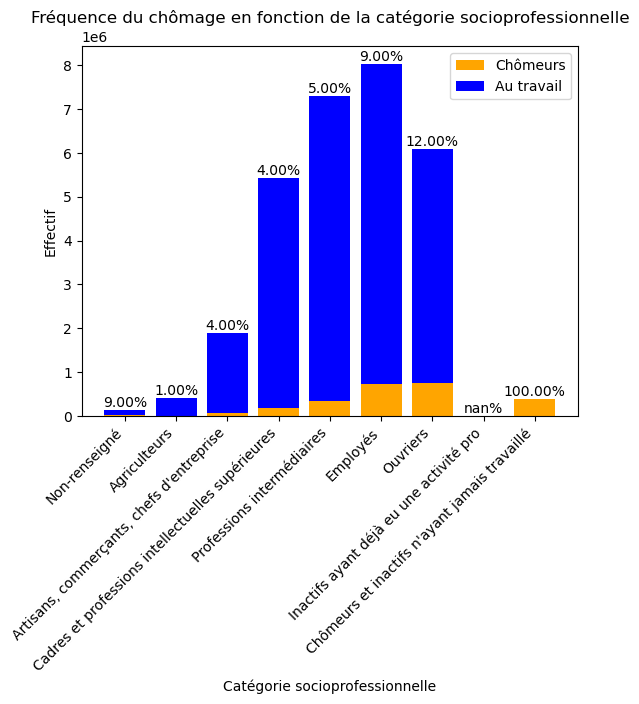

In [8]:
# Bar plot
bars1 = plt.bar(data["CSTOTR"], data["Effectif_chom"], color='orange', label='Chômeurs')
bars2 = plt.bar(data["CSTOTR"], data["Effectif_emploi"], color='blue', label='Au travail', bottom=data["Effectif_chom"])

# Title and labels
plt.title('Fréquence du chômage en fonction de la catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Effectif')
plt.xticks(data["CSTOTR"], categories, rotation=45, ha='right')
plt.legend()

# Annotate bars with proportions
for bar1, bar2, prop in zip(bars1, bars2, data["Proportion_chom"]):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{prop:.2%}', ha='center', va='bottom')

plt.show()


On observe clairement une différence d'exposition au chômage liée aux catégories socioprofessionnelles, les employés et les ouvriers étant les catégories les plus touchées, tant du point de vue du nombre absolue de chômeurs, que du taux de chômage au sein des catégories. Ces résultats sont conformes à la littérature sur la question du chômage, et peuvent s'expliquer en premier lieu par le niveau de qualification plus faible de ces populations (la forte proportion d'ouvriers au chômage renvoyant aussi aux tranformations structurelles de l'économie française depuis un demi siècle).

## D - Age

In [9]:
#chômage par âge
#Catégories possibles
categories = ["15-29","30-39","40-49","50-59","60+"]

#tableau avec AGE/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"AGE5": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in [15,30,40,50, 60] :
    somme_pond_E = EEC_2019[(EEC_2019["AGE5"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

,AGE5,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,15-29,5072465.0,914344.0,0.08,5376700.0,0.47
1,30-39,6564533.0,561016.0,0.07,1023848.0,0.13
2,40-49,7118749.0,467806.0,0.05,936926.0,0.11
3,50-59,6670976.0,441541.0,0.05,1610603.0,0.18
4,60+,1749306.0,121474.0,0.01,15015340.0,0.89


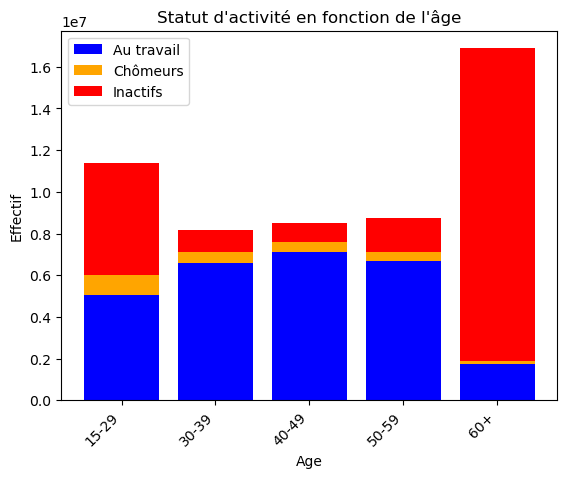

In [10]:
plt.bar(data["AGE5"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["AGE5"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["AGE5"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction de l'âge")
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.xticks(data["AGE5"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

De façon attendue, les inactifs se concentrent principalement parmi les populaions les plus jeunes (15 à 29 ans), qui peuvent pour une part importante d'entre elles être toujours en étude, ou connaitre une insertion difficile sur le marché du travail, et les populations les plus jeunes, de plus de 60 ans (l'enquête emploi couvre la population françaie jusqu'à 89 ans), ceux-ci étant très largement retraitées. Néanmoins, alors que le chômage est important pour les jeunes (renvoyant entre autre à cette insertion dificile sur le marché du travail), Celui-ci est particulèrement faible pour les plus de 50 ans, ceux-ci disposant de plusieurs ressources protectrices (expérience, stabilité de l'emploi acquise avec le temps...) et étant de plus plus susceptible de basculer dans l'inactivité en cas de difficultés liées à l'emploi, par un départ à la retaite plus ou moins anticipé.
La tranche d'âge allant de 30 à 60 ans recense de son côté principalement des actifs (entre 5 et 7% de chômage et environ 15% d'inactifs).

## E - Sexe

In [11]:
#chômage et inactivité par sexe
#Catégories possibles
categories = ["Homme","Femme"]
value = [1,2]

#tableau avec SEXE/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"SEXE": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["SEXE"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),3))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

,SEXE,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,Homme,13991783.0,1300459.0,0.051,10321696.0,0.40
1,Femme,13184246.0,1205722.0,0.043,13641720.0,0.49


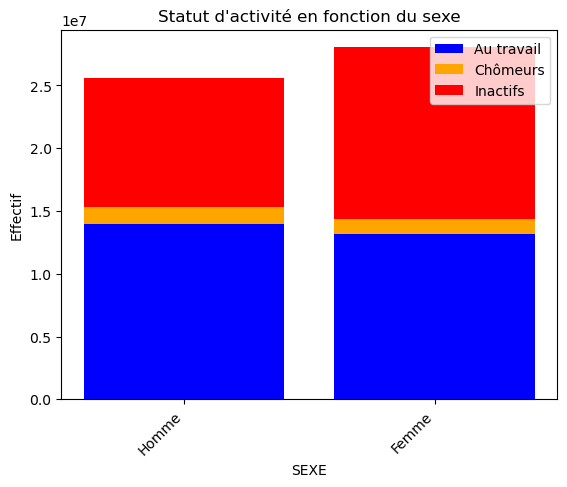

In [12]:
plt.bar(data["SEXE"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["SEXE"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["SEXE"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('SEXE')
plt.ylabel('Effectif')
plt.xticks(data["SEXE"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

Si le nombre de femmes inactives est supérieur au nombre d'hommes inactifs, cela s'explique principalement par l'écart d'espérance de vie entre les femmes et les hommes, les femmes vivant plus longtemps en moyenne elles sont donc plus nombreuses à être retraitées. Néanmoins, nous remarquons que le nombre d'actifs chez les femmes est légérement inférieur, ce qui semble indiquer le maintien d'une différence en terme de taux d'activité, légérement inférieur pour les femmes (ce qui indique le maintien d'un rapport sexué, bien que de façon mineure, à l'activité).
Concernant le taux de chômage, il n'y a pas de différence clairement visible ce qui nous incite à recourir à un test statistique pour vérifier si la probabilité d'être au chômage est la même pour un homme et pour une femme.

In [13]:
#On effectue un test de proportion z pour savoir s'il y a un écart statistique important entre le 
#taux de chômage des femmes et des hommmes. 

# Nombre d'observations dans chaque groupe
nobsh = data.loc[data["SEXE"]=="Homme"]["Effectif_chom"]+data.loc[data["SEXE"]=="Homme"]["Effectif_inac"]+data.loc[data["SEXE"]=="Homme"]["Effectif_emploi"]
nobsf = data.loc[data["SEXE"]=="Femme"]["Effectif_chom"]+data.loc[data["SEXE"]=="Femme"]["Effectif_inac"]+data.loc[data["SEXE"]=="Femme"]["Effectif_emploi"]

# Proportion dans chaque groupe
proph = data.loc[data["SEXE"]=="Homme"]["Proportion_chom"]
propf = data.loc[data["SEXE"]=="Femme"]["Proportion_chom"]

# Effectuer le test de proportion de z
z_stat, p_value = sm.stats.proportions_ztest([proph * nobsh, propf * nobsf], [nobsh, nobsf])

# Afficher les résultats
print(f"Z-statistique: {z_stat}")
print(f"p-valeur: {p_value}")

Z-statistique: [138.54271076]
p-valeur: [0.]


La Z-statistique est élevée et la p-valeur est très faible, on peut donc conclure que les femmes ont en effet statistiquement moins de chance d'être au chômage que les hommes. Ceci s'explique avant tout par les différences d'exposition au chômage des secteurs d'activité où l'on retrouve plus de femmes ou plus d'hommes (https://www.insee.fr/fr/statistiques/6047737?sommaire=6047805).

## F - Catégorie de commune

In [14]:
#chômage et inactivité par taille et position géographique de la commune
#Catégories possibles
categories = ["Grandes aires urbaines","Autres aires","Autres communes multipolarisées","Communes isolées hors influence des pôles"]
value = EEC_2019["CATAU2010R"].unique()

#tableau avec CAUTAU2010R/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"CATAU2010R": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CATAU2010R"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

,CATAU2010R,Effectif_emploi,Effectif_chom,Proportion_chom,Effectif_inac,Proportion_inac
0,Grandes aires urbaines,23126279.0,2146020.0,0.05,19554222.0,0.44
1,Autres aires,1059157.0,69715.0,0.03,1139339.0,0.50
2,Autres communes multipolarisées,1462749.0,106304.0,0.04,1379678.0,0.47
3,Communes isolées hors influence des pôles,1527845.0,184143.0,0.05,1890178.0,0.52


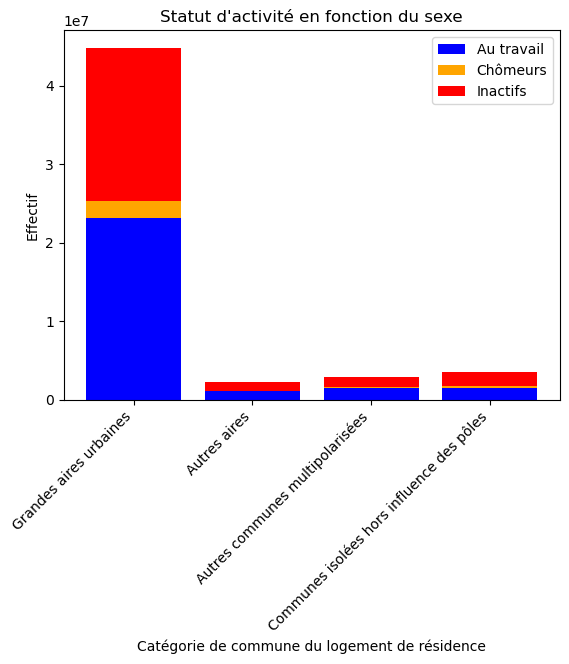

In [15]:
plt.bar(data["CATAU2010R"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["CATAU2010R"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["CATAU2010R"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('Catégorie de commune du logement de résidence')
plt.ylabel('Effectif')
plt.xticks(data["CATAU2010R"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

# II - Analyse en composantes principales

On va effectuer une analyse en composantes principales sur la base EEC 2019 en essayant de se concentrer sur des variables socio-démographiques disponibles pouvant être correlées (voire expliquées) le statut d'activité.
On s'intéresse au sexe, au niveau d'études, à la catégorie socioprofessionnelle, à la nationalité, au nombre d'heures travaillées voulues, à l'ancienneté du chômage, à l'âge, à la catégorie de la commune et à des variables familialles (couple ? enfants ?), à l'implication dans la recherche d'emploi.

## A - Normalisation

Pour commencer, on doit transformer les variables catégorielles en indicatrices et normaliser entre 0 et 1 les variables numériques.

In [16]:
#Création d'une base PCA
EEC_PCA=EEC_2019
EEC_PCA=pd.DataFrame(EEC_PCA[["EXTRIAN","ACTEU","SEXE","DIP11","CSTOTR","NFRRED","HPLUSA","HHCE","CONTACT",
"ANCCHOM","AGE5","AIDFAM","CATAU2010R","COURED","ENFRED"]]).reset_index(drop=True)

In [17]:
#ACTEU : le statut d'activité, création d'une indicatrice chômage et d'une indicatrice inactif
EEC_PCA["CHOM"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==2, "CHOM"]=1

EEC_PCA["INAC"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==3, "INAC"]=1

In [18]:
#DIP11 que l'on va séparer en indicatrices pour enseignement sup, secondaire et en dessous
EEC_PCA["infcollege"]=0 #infcollege = aucun diplome, certif d'études, brevet
EEC_PCA.loc[EEC_PCA["DIP11"].isin([71,70,60]), "infcollege"]=1

EEC_PCA["secondaireplus"]=0 #secondaire plus = secondaire + BTS et DUT...
EEC_PCA.loc[EEC_PCA["DIP11"].isin([50,42,41,33,31]), "secondaireplus"]=1

EEC_PCA["sup"]=0 #le reste
EEC_PCA.loc[EEC_PCA["DIP11"].isin([30,11,10]), "sup"]=1

In [19]:
#SEXE (0 = H, 1 = F)
EEC_PCA.loc[EEC_PCA["SEXE"]==1, "SEXE_bin"]=0
EEC_PCA.loc[EEC_PCA["SEXE"]==2, "SEXE_bin"]=1

In [20]:
#CSTOTR : en se basant sur le graphique ci-dessus, je crée une catégorie employé avec les professions intermédiaires, les employés et les ouvriers
#et je crée une catégorie employeur avec les cadres sups, artisans, chef d'entreprises
EEC_PCA["employe"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([4,5,6]), "employe"]=1

EEC_PCA["employeur"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([2,3]), "employeur"]=1
#on a 3/4 de l'échantillon employe et 1/4 employeur

In [21]:
#NFRRED : variable indicatrice : "l'individu est-il de nationalité française ?"
EEC_PCA["NAT"]=0
EEC_PCA.loc[EEC_PCA["NFRRED"].isin([1,2]), "NAT"]=1
#1/20 sans nationalité FR

In [22]:
#AGE5 : transformer en deux indicatrices jeunes (15 à 29 ans) ou âgés (plus de 50 ans)
EEC_PCA["JEUNE"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"]==15, "JEUNE"]=1

EEC_PCA["ANCIEN"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([50,60]), "ANCIEN"]=1
#1/5 de jeunes et 1/3 d'anciens

In [23]:
#CONTACT : contact avec pôle emploi depuis dernière enquête (3 mois), 1 si oui
EEC_PCA["P_E"]=0
EEC_PCA.loc[EEC_PCA["CONTACT"]==1, "P_E"]=1
#moins d'1/20

In [24]:
#création de rural. 1 si l'individu n'habite pas dans un grande aire urbaine : 1/5 échantillon
EEC_PCA["rural"]=1
EEC_PCA.loc[EEC_PCA["CATAU2010R"]==1, "rural"]=0

In [25]:
#COURED : 1 si l'individu est en couple
EEC_PCA["COUPLE"]=0
EEC_PCA.loc[EEC_PCA["COURED"]==1, "COUPLE"]=1
#2/3 en couple

In [26]:
#ENFRED : 1 si l'individu a un enfant
EEC_PCA["ENF"]=0
EEC_PCA.loc[EEC_PCA["ENFRED"]==1, "ENF"]=1
#la moitié a un enfant

In [27]:
#HPLUSA (beaucoup d'informations manquantes, surtout les personnes ne voulant pas modifier leur charge horraire, on va donc prendre 
#leur charge horraire actuelle comme souhait.
EEC_PCA["HHCE"]=EEC_PCA["HHCE"].fillna(0)
EEC_PCA.loc[EEC_PCA['HPLUSA'].isna(), "HPLUSA"]=EEC_PCA[EEC_PCA['HPLUSA'].isna()]["HHCE"]

In [28]:
col = EEC_PCA['HPLUSA']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['HPLUSA'] = colonne_normalisee
EEC_PCA["HPLUSA"].describe()

count    416298.000000
mean          0.174642
std           0.201204
min           0.000000
25%           0.000000
50%           0.000000
75%           0.361809
max           1.000000
Name: HPLUSA, dtype: float64

In [29]:
#ANCCHOM : recodage en mois
EEC_PCA["ANCCH"]=0.0#en emploi
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==1, "ANCCH"]=1.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==2, "ANCCH"]=2.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==3, "ANCCH"]=4.5
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==4, "ANCCH"]=9.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==5, "ANCCH"]=15.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==6, "ANCCH"]=21.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==7, "ANCCH"]=30.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==8, "ANCCH"]=40.0
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.680171
std           4.274341
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: ANCCH, dtype: float64

In [30]:
col = EEC_PCA['ANCCH']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['ANCCH'] = colonne_normalisee
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.017004
std           0.106859
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ANCCH, dtype: float64

## B - Matrice de covariances

Avec ces variables normalisées, on réalise maintenant la matrice de covariances et sa heatmap. On veille à respecter la pondération de chaque individu.

In [31]:
EEC_PCAW=EEC_PCA["EXTRIAN"].to_numpy() #pour pondérer
EEC_PCA1=EEC_PCA[['HPLUSA', 'CHOM','INAC', 'infcollege', 'P_E',"ANCCH",
       'secondaireplus', 'sup', 'SEXE_bin', 'employe', 'employeur', 'NAT',
       'JEUNE', 'ANCIEN', 'rural', 'COUPLE', 'ENF']]
noms_var=EEC_PCA1.columns #pour la mise en forme de la matrice de covariances
EEC_PCA1.head()

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,rural,COUPLE,ENF
0,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,0,0
1,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,1,0
2,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,1,0
3,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,1,0
4,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,1,0


In [32]:
EEC_COV_NP=np.cov(EEC_PCA1.to_numpy(), rowvar=False, aweights=EEC_PCAW)
EEC_COV=pd.DataFrame(EEC_COV_NP) #matrice de covariance pondérée
EEC_COV.columns = noms_var #on affiche le nom des variables correspondantes en x et y
EEC_COV.set_index(EEC_COV.columns, inplace=True)
EEC_COV

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,rural,COUPLE,ENF
HPLUSA,0.041428,-0.008964,-0.085715,-0.031662,-0.002925,-0.003011,0.013564,0.017932,-0.013064,0.054870,0.029508,0.001684,-0.006544,-0.032863,-0.002920,0.018821,0.034300
CHOM,-0.008964,0.044535,-0.020869,-0.000803,0.012456,0.014957,0.002101,-0.001355,-0.001936,0.015565,-0.001420,-0.002415,0.007148,-0.011807,-0.000966,-0.007126,0.001146
INAC,-0.085715,-0.020869,0.247160,0.079704,-0.005615,-0.007009,-0.038920,-0.040319,0.020878,-0.178377,-0.061053,-0.000551,0.005604,0.096678,0.008756,-0.037614,-0.087091
infcollege,-0.031662,-0.000803,0.079704,0.208357,-0.000811,0.000647,-0.150956,-0.056733,0.008364,-0.046182,-0.032312,-0.013112,0.003213,0.041956,0.009851,-0.028624,-0.032177
P_E,-0.002925,0.012456,-0.005615,-0.000811,0.026948,0.004723,0.002093,-0.001358,-0.000013,0.005873,-0.001267,-0.001316,0.001312,-0.005720,0.000012,-0.002581,0.002626
ANCCH,-0.003011,0.014957,-0.007009,0.000647,0.004723,0.009866,0.000281,-0.000941,-0.000745,0.005101,-0.000570,-0.000973,0.000714,-0.002454,-0.000276,-0.002567,0.000701
secondaireplus,0.013564,0.002101,-0.038920,-0.150956,0.002093,0.000281,0.249899,-0.097790,-0.010525,0.060223,-0.022868,0.013658,-0.001734,-0.016560,0.005361,0.014673,0.018450
sup,0.017932,-0.001355,-0.040319,-0.056733,-0.001358,-0.000941,-0.097790,0.154956,0.002329,-0.013622,0.055321,-0.000477,-0.002097,-0.024736,-0.014976,0.014304,0.013745
SEXE_bin,-0.013064,-0.001936,0.020878,0.008364,-0.000013,-0.000745,-0.010525,0.002329,0.249493,-0.000091,-0.018542,-0.000008,-0.004576,0.007778,-0.001049,-0.013818,0.012492
employe,0.054870,0.015565,-0.178377,-0.046182,0.005873,0.005101,0.060223,-0.013622,-0.000091,0.239865,-0.054577,-0.000556,0.004219,-0.076915,-0.002042,0.019490,0.061240


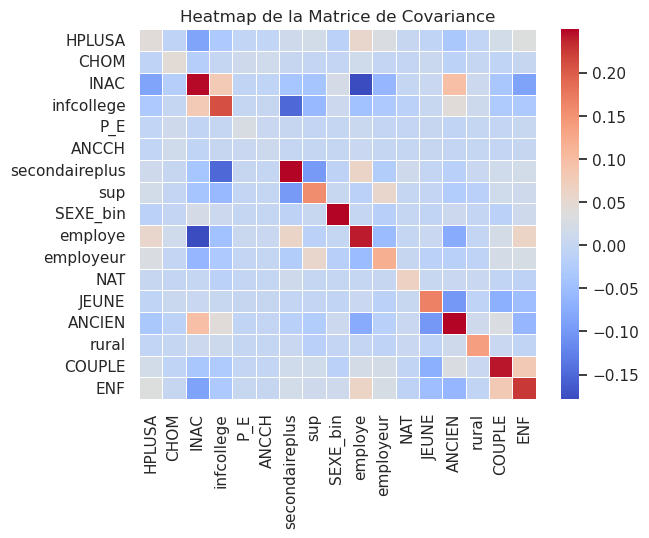

In [33]:
# Utiliser seaborn pour créer la heatmap
sns.set(style="white")
sns.heatmap(EEC_COV, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Afficher la heatmap
plt.title('Heatmap de la Matrice de Covariance')
plt.show()

La heatmap met en évidence des caractéristiques intéressantes au sein de notre ensemble de données. Il est notable que des variables telles que HPLUSA, CHOM, P_E, ANCCH, employeur et NAT présentent une faible variance. Cette faible variance s'explique par le fait que ces variables sont soit peu réparties dans l'échantillon total, comme c'est le cas pour employeur, qui ne concerne qu'un quart de l'échantillon, soit qu'elles représentent seulement un sous-ensemble spécifique de la population, comme ANCCH qui mesure l'ancienneté du chômage.

En outre, des corrélations logiques émergent dans la heatmap, souvent attribuables à l'encodage des variables. Par exemple, les corrélations entre employeur et employé, chômage et inactivité reflètent les relations naturelles entre ces états.

Par ailleurs, des corrélations particulièrement intéressantes se dégagent : une corrélation positive entre le fait d'être employé et d'avoir des enfants, ou d'avoir plus de 50 ans et d'avoir comme dernier diplôme le brevet (témoignant d'un allongement du parcours scolaire moyen depuis les années 1960). On observe également une corrélation positive entre la variable enseignement supérieur et la variable employeur, et une corrélation négative avec la variable rurale. Ces associations soulignent des tendances significatives dans les relations entre différentes dimensions de notre ensemble de données.

## C - ACP

On réalise maintenant l'analyse en composantes principales.

In [34]:
# Appliquer la PCA
pca = PCA()
composantes_principales = pca.fit(EEC_COV).components_

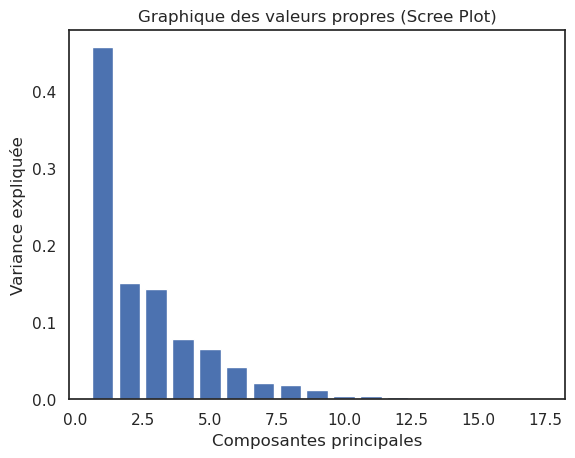

In [35]:
# Graphique des valeurs propres
valeurs_propres = pca.explained_variance_ratio_
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres)
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Graphique des valeurs propres (Scree Plot)')
plt.show()

Assez classiquement pour une ACP, on remarque que la première composante est très "explicative" de la répartition de nos individus selon ces variables, au sens où elle regroupe à elle seule une très grande part de la variance de notre nuage de points.

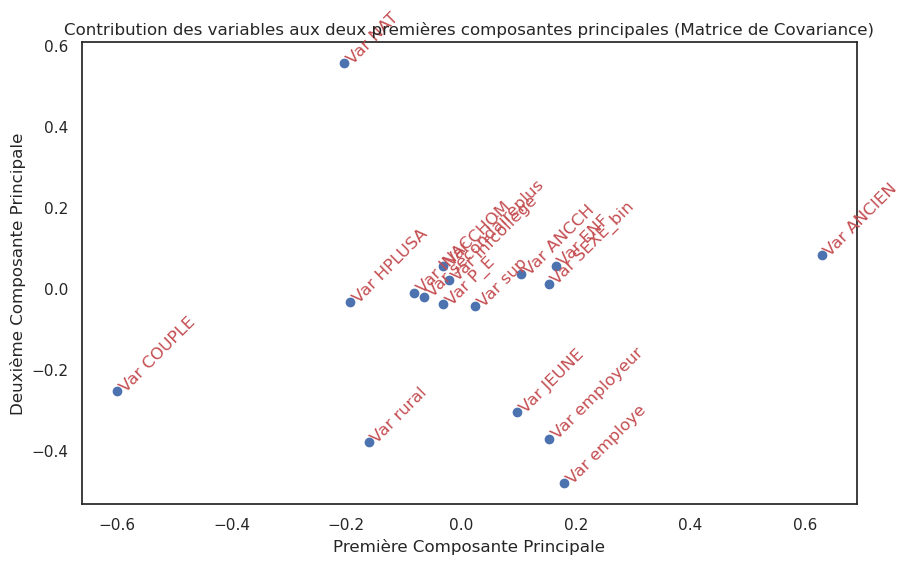

In [36]:
# Sélectionner les deux premiers vecteurs propres
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = EEC_COV.columns.tolist()

# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

La première composante principale, qui contribue de manière prépondérante à l'explication de la variance, est fortement associée à la population âgée, principalement constituée de personnes de plus de 50 ans qui sont célibataires. Bien que cette composante ne les catégorise pas nécessairement comme inactifs (étant donné la présence de nombreux inactifs parmi les jeunes), elle souligne leur préférence pour une charge horaire de travail nulle, suggérant une orientation vers la retraite. Ces individus sont principalement localisés en milieu urbain et occupent des postes d'employés. Il convient de noter que cette observation peut être influencée par le fait qu'une grande partie de la population générale est également urbaine ou employée.

La deuxième composante principale, bien que moins significative, caractérise une population située principalement entre 30 et 50 ans, excluant les catégories jeunes et âgées. Cette population se distingue par sa nationalité française, son statut célibataire et son habitation en milieu urbain. Une particularité intéressante est l'absence de corrélation significative avec les variables "employé" et "employeur". Cette population semble possiblement liée aux métiers agricoles, au chômage ou à l'inactivité, ce qui suggère une diversité dans les parcours professionnels au sein de ce groupe d'âge.

# III - Modélisation

## A - Preprocessing

In [3]:
# On choisit un ensemble de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié et qui sont disponibles sur les deux années étudiées

# Notre variable d'intérêt ici est ACTEU

# Variables à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ;
# DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# Pour la prise en compte de la PCS, il n'est pas possible d'utiliser CSTOT /  CSTOTPRM / CSTOTR
# Ce sont des variables qui distinguent les actifs des non-actifs
# Possibilité de recoder à partir de CSP et CSA

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSA" ,"CSP" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected] 

list_var = list(EEC_2019.columns.values)
print(list_var)

['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSA', 'CSP', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']


### Recodage d'une variable de PCS à deux niveaux regroupant actifs occupés et les autres

Pour pouvoir utiliser la PCS dans notre modèle de prédiction, nous ne pouvons pas utiliser, comme nous l'aurions souhaité, la variable présente dans la base pour l'ensemble des individus, car celle-ci distingue les chômeurs et les inactifs. Or, nous cherchons à utiliser l'information de la PCS pour prédire le statut d'emploi, nous avons donc besoin pour cela d'une PCS qui ne contienne pas déjà cette information. Nous recodonc donc une variable PCS (à deux niveaux) pour laquelle, conformément à la définition de la PCS, nous affectons les chômeurs et les inactifs à la PCS correspondant à leur dernier emploi.

In [4]:
#On commence par vérifier que les variables CSP (actifs occupés) et CSA (non actifs occupés) ne sont pas renseignées pour les mêmes individus

non_nan_csp = EEC_2019['CSP'].notna()
non_nan_csa = EEC_2019['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

Les variables ne sont pas renseignées pour les mêmes individus


In [5]:
#On peut donc sommer les deux colonnes pour obtenir la valeur voulue
EEC_2019['PCS'] = EEC_2019['CSA'].add(EEC_2019['CSP'], fill_value=0)

pcs_manquante = EEC_2019['PCS'].isna().sum()

print(pcs_manquante)
#1260 valeurs manquantes, donc assez peu

1260


In [6]:
#Idem pour EEC_2020
#Création d'une variable de PCS avec la PCS des actifs occupés et l'ancienne des inactifs et chômeurs.
non_nan_csp = EEC_2020['CSP'].notna()
non_nan_csa = EEC_2020['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

#On peut donc sommer les deux colonnes
EEC_2020['PCS'] = EEC_2020['CSA'].add(EEC_2020['CSP'], fill_value=0)

pcs_manquante = EEC_2020['PCS'].isna().sum()

print(pcs_manquante)
#864 valeurs manquantes, donc très peu

Les variables ne sont pas renseignées pour les mêmes individus
864


In [7]:
#Attention, notre variable 'PCS' contient une modalité en 2019,qui n'existe pas en 2020
#Cela vient de la modalité "10" de la PCS ("agriculteur") qui n'existe pas pour 2020, et uniquement chez des non actifs occupés
#On peut supposer qu'il s'agit d'agriculteurs pour lesquels la taille d'exploitation n'a pu être déterminée...
#Cela ne concerne que deux observations
EEC_2019['PCS'].value_counts()[0]
print(EEC_2019.shape)
#Lors de la conversion de la variable en indicatrice, nous allons donc obtenir des bases de tailles différentes
#pour éviter cela, on décide de supprimer ces deux observations
EEC_2019 = EEC_2019[EEC_2019['PCS'] != 10]
print(EEC_2019.shape)

(416298, 16)
(416296, 16)


In [8]:
#On enlève de la base les variables CSA et CSP
EEC_2019 = EEC_2019.drop(['CSA', 'CSP'], axis=1)
EEC_2020 = EEC_2020.drop(['CSA', 'CSP'], axis=1)

### Analyses des NA de notre base

Les modèles que nous souhaitons appliquer nécessitent des bases complètes, et ne peuvent fonctionner dès lors que nous avons des valeurs manquantes. La solution la plus simple à ce problème est de supprimer de la base les individus pour lesquels les informations nous manquent. Avant de faire cela, nous vérifions quelles sont les informations manquantes, et le nombre d'observations concernées.
Nous remarquons que l'information manquante est systématiquement le diplôme (ainsi qu'éventuellement le statut d'emploi et la PCS, voir la nationalité) mais pour un nombre très limité d'observation ce qui justifie la suppression de ces observations.

In [9]:
#Comptons le nombre de NaN dans nos df
nombre_lignes_nan_2019 = EEC_2019.isnull().any(axis=1).sum()
nombre_lignes_nan_2020 = EEC_2020.isnull().any(axis=1).sum()
print(nombre_lignes_nan_2019)
print(nombre_lignes_nan_2020)

4205
3379


In [10]:
#Isolons nos observations avec des NAN
EEC_2019_with_nulls = EEC_2019[EEC_2019.isna().any(axis=1)]
EEC_2020_with_nulls = EEC_2020[EEC_2020.isna().any(axis=1)]

In [11]:
print(EEC_2019_with_nulls.shape)
print(EEC_2020_with_nulls.shape)

(4205, 14)
(3379, 14)


In [12]:
EEC_2019_with_nulls = EEC_2019_with_nulls.copy()
EEC_2019_with_nulls['total_nan'] = EEC_2019_with_nulls.isna().sum(axis=1)

In [13]:
print(EEC_2019_with_nulls['total_nan'].mean())
#En moyenne, 1,79 valeurs manquantes, sur 14 variables

1.7938168846611178


In [14]:
#On affiche un tableau avec le nombre de NAN par variable, et le pourcentage des observations manquantes que cela représente
nan_count_variable_2019 = EEC_2019_with_nulls.isna().sum()
print(nan_count_variable_2019)
nan_percentage_variable_2019 = (EEC_2019_with_nulls.isna().sum() / len(EEC_2019_with_nulls)) * 100
print(nan_percentage_variable_2019)
#A chaque fois il nous manque donc le diplôme, et dans environ un tiers des cas la PCS recodée et la variable d'intérêt, un cinquième des nationalités

ACTEU         1260
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         4205
ENFRED           0
METRODOM         0
NFRRED         818
SEXE             0
TYPMEN7          0
PCS           1260
total_nan        0
dtype: int64
ACTEU          29.964328
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED         19.453032
SEXE            0.000000
TYPMEN7         0.000000
PCS            29.964328
total_nan       0.000000
dtype: float64


In [15]:
#Même chose pour 2020
EEC_2020_with_nulls = EEC_2020_with_nulls.copy()
EEC_2020_with_nulls['total_nan'] = EEC_2020_with_nulls.isna().sum(axis=1)
print(EEC_2020_with_nulls['total_nan'].mean())
#En moyenne, 1,67 valeurs manquantes, sur 14 variables
nan_count_variable_2020 = EEC_2020_with_nulls.isna().sum()
print(nan_count_variable_2020)
nan_percentage_variable_2020 = (EEC_2020_with_nulls.isna().sum() / len(EEC_2020_with_nulls)) * 100
print(nan_percentage_variable_2020)
#On retrouve des choses très semblables sur 2020, avec encore une fois surtout le diplôme qui manque

1.6738680082864752
ACTEU          864
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         3377
ENFRED           0
METRODOM         0
NFRRED         551
SEXE             0
TYPMEN7          0
PCS            864
total_nan        0
dtype: int64
ACTEU         25.569695
ANNEE          0.000000
TRIM           0.000000
AGE3           0.000000
AGE5           0.000000
CATAU2010R     0.000000
COURED         0.000000
DIP11         99.940811
ENFRED         0.000000
METRODOM       0.000000
NFRRED        16.306600
SEXE           0.000000
TYPMEN7        0.000000
PCS           25.569695
total_nan      0.000000
dtype: float64


In [16]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls.dropna(subset=['ACTEU'])
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.copy()
EEC_2019_with_nulls_non_ACTEU['total_nan'] = EEC_2019_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2019_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2019_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2019_non_ACTEU)
nan_percentage_variable_2019_non_ACTEU = (EEC_2019_with_nulls_non_ACTEU.isna().sum() / len(EEC_2019_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2019_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

1.0122241086587436
ACTEU            0
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         2945
ENFRED           0
METRODOM         0
NFRRED          36
SEXE             0
TYPMEN7          0
PCS              0
total_nan        0
dtype: int64
ACTEU           0.000000
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED          1.222411
SEXE            0.000000
TYPMEN7         0.000000
PCS             0.000000
total_nan       0.000000
dtype: float64


In [17]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls.dropna(subset=['ACTEU'])
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.copy()
EEC_2020_with_nulls_non_ACTEU['total_nan'] = EEC_2020_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2020_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2020_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2020_non_ACTEU)
nan_percentage_variable_2020_non_ACTEU = (EEC_2020_with_nulls_non_ACTEU.isna().sum() / len(EEC_2020_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2020_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

1.0127236580516898
ACTEU            0
ANNEE            0
TRIM             0
AGE3             0
AGE5             0
CATAU2010R       0
COURED           0
DIP11         2515
ENFRED           0
METRODOM         0
NFRRED          32
SEXE             0
TYPMEN7          0
PCS              0
total_nan        0
dtype: int64
ACTEU           0.000000
ANNEE           0.000000
TRIM            0.000000
AGE3            0.000000
AGE5            0.000000
CATAU2010R      0.000000
COURED          0.000000
DIP11         100.000000
ENFRED          0.000000
METRODOM        0.000000
NFRRED          1.272366
SEXE            0.000000
TYPMEN7         0.000000
PCS             0.000000
total_nan       0.000000
dtype: float64


In [18]:
# Il y a très peu de valeurs manquantes dans les variables, 4205 variables concernées en 2019, 3379 en 2020.
#Si on supprime d'office les observations pour lesquelles manquent la variable d'intérêt, on tombe à 2945 et 2515, et c'est systématiquement le diplôme qui manque
#On choisit donc de les supprimer de la base pour le moment
print(EEC_2019.shape)
print(EEC_2020.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)
print(EEC_2020.shape)

(416296, 14)
(319398, 14)
(412091, 14)
(316019, 14)


### Suite et fin du préprocessing

In [19]:
# Conversion de l'ensemble des variables catégorielles en indicatrices
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS", "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE des variables binaires

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#On retire les variables non recodées
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 73 variables
print(EEC_2019.shape)
print(EEC_2020.shape)

(412091, 73)
(316019, 73)


#### Création de notre sous-ensemble, et de nos array pour sklearn

Face au temps de calcul très long des programmes de recherche des hyperparamètres optimaux type GridSearch, nous faisons le choix de nous concentrer pour ces phases sur un sous-échantillon aléatoire limité à 10 000 observations, et d'une manière générale la suite de ce Notebook n'effectuera les calculs que sur ce sous-échantillon, mais nous intégrerons aussi des matrices de confusion pour lesquelles l'ajustement du modèle ("fit") porte sur l'ensemble de la base (voir dossier "Results")

In [20]:
#Pour rendre les calculs plus rapide, on se concentre sur un sous-ensemble
EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 

In [21]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.5283
True     0.4717
Name: proportion, dtype: float64


In [22]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5215
Name: FEMME, dtype: object


In [23]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)

(10000, 69)
(10000,)


In [24]:
#création de nos ensemble de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=4)

## B - Support Vector Machine

Nous essayons ici d'appliquer un modèle de type SVM pour prédire la situation d'emploi à partir des variables socio-démographiques, en essayant de sélectionner le paramètre régularisation qui permet la meilleure précision sur notre (sous)-échantillon de test.

In [25]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))

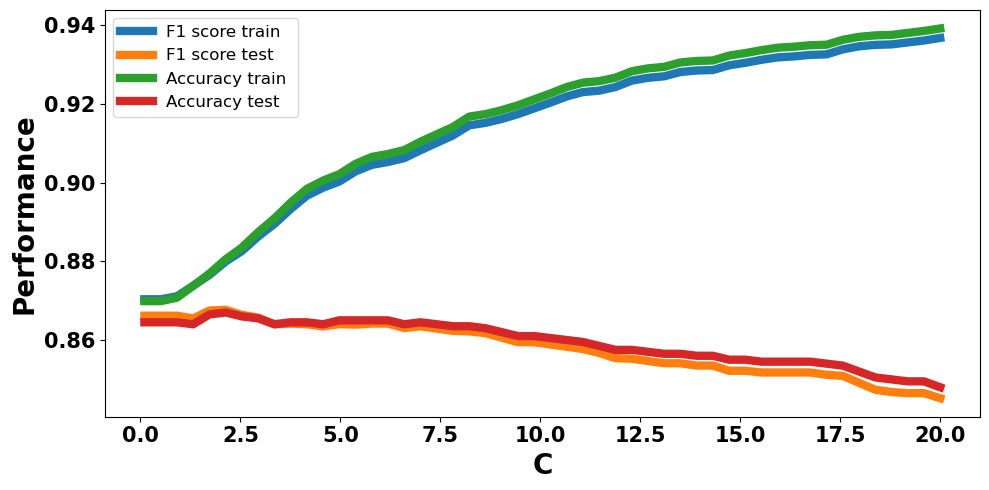

In [26]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

Il semble ici que très vite la performance diminue sur le test, dès des valeurs assez petites du paramètre C, ce qui indique que le modèle de SVM rentre très vite dans une phase de surapprentissage : on s'attends à ce que notre modèle ne sélectionne qu'un nombre limité de variables.

In [27]:
#utilisation de GridSearch pour trouver le meilleur paramètre de régularisation
params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 3.9797959183673464}
0.897125
0.8645


Comme attendu, GridSearch nous propose donc un paramètre de régularisation faible, autours de 2,85, avec un score de 0,896, signifiant que 89,6% de nos observations du test sont correctement prédites.

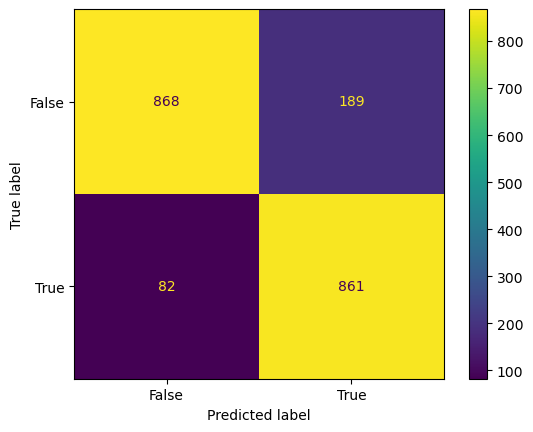

In [29]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

Nous pouvons ainsi constater ici une relativement bonne performance de notre modèle sur la partie de test de notre sous-échantillon, ce que nous pouvions anticiper au vu du score. Ceci pourrait sembler surprenant car nous n'utilisons ici que des variables socio-démographiques, ce qui confirme que les déterminants socio-économiques du chômage sont prédpondérants sur les parcours inidviduels dès lors que l'on s'intéresse au statut vis à vis de l'activité d'un individu.
Nous pouvons aussi remarquer que notre modèle se trompe nettement plus en prédisant une situation d'actif occupé pour des gens qui ne le sont pas (182) qu'en prédisant une situationde chômage ou d'inactivité pour des individus en emploi (82). Ainsi, notre modèle est légérement "biaisé vers l'emploi", peut-être en ayant du mal à saisir la situation des chômeurs, particulièrement de courte durée, pour lesquels on s'atends à avoir des caractéristiques sociodémographiques proches des actifs occupés.

### Utilisation du modèle SVM sur la base entière de 2019
![Confusion_Matrix_2019](Results/SVM/Confusion_Matrix_2019.png "Matrice de confusion Test 2019")

Afin de ne pas se limiter aux résultats sur le sous-échantillon de 2019, nécessairement limité, nous avons procéder à une analyse dans laquelle nous reprenons les spécifications pour notre modèle SVM issues de GridSearch obtenues à partir du sous-échantillon, mais en effectuant l'ajustement du modèle sur un sous-échantillon d'apprentissage de 2019 et en testant la prédiction sur un sous-échantillon de test pour la même année (le code utilisée se trouve dans le document "Script_III_B_C.py")

Comme on peut le voir, les éléments de conclusion restent  très sensiblement les mêmes. Le score est désormais de 0,872, soit 87,2% de bonnes prédictions, avec là encore une prédiction qui semble biaisée vers l'emploie, dans le même ordre de grandeur.

### Utilisation du modèle SVM pour prédire en 2020
![Confusion_Matrix_2020](Results/SVM/Confusion_Matrix_2020_fit_2019.png "Matrice de confusion 2020")

De la même façon, nous avons choisi de procéder à l'ajustement du modèle sur l'ensemble de la base de 2019, pour prédire le statut d'emploi en 2020, même si l'on s'attend ici à voir une légère baisse de notre score puisque les conditions macro-économiques en 2019 et en 2020 étaient différentes, l'année 2020 ayant de plus été très particulière vec l'épidémie de Covid. Néanmoins, nous conservons de très bons résultats, le score étant désormais de 0,866, soit 86,6% de bonnes prédictions. Nous voyons néanmoins que notre "biais vers l'emploi" semble plus élevé encore, puisque nous avons trois fois plus de faux positifs que de faux négatifs, mais ceci est cohérent avec une année 2020 durant laquelle l'épidémie de Covid a pu éloigner de l'emploie des populations qui auraient autrement été en emploi.

## C - Regression logistique

Nous essayons ici une autre méthode, à savoir la régression logistique, qui présente de plus la possibilité d'être plus facilement interprétable et de pouvoir tracer les variables utilisées par le modèle, ainsi que les coefficients associés le cas échéant.

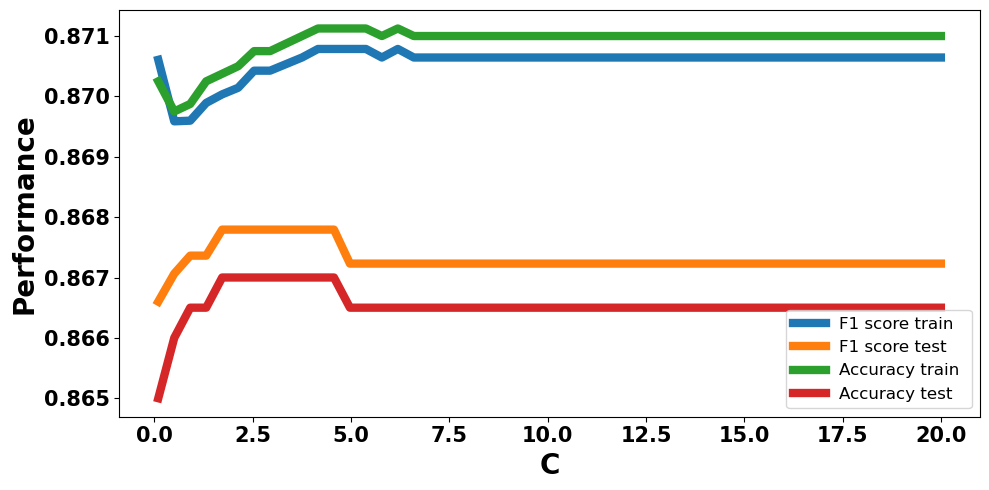

In [25]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

In [26]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
#ainsi que le critère de penalty et le tol (tolerance for stopping criteria)

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.1030204081632653, 'tol': 0.1}
0.869875
0.8645


Le modèle choisit atteint une précision de l'ordre de 86,5% sur le test, ce qui est légérement moins efficace que le modèle SVM de la partie précédente

In [27]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
#Conserve la grande majorité des variables

Number of variables considered: 68


Ainsi, notre modèle de régression logistique conserve la quasi totalité des variables (nos Array contiennent 73 variables explictives, sous forme d'indicatrice). 

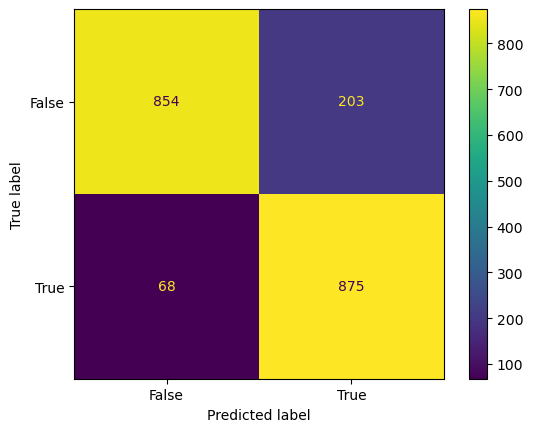

In [32]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

Ainsi, notre modèle logistique a le même type de comportement que notre modèle SVM, avec une précision semblable sur le test, et le même "biais vers l'emploi", mais encore plus marqué, ce qui s'explique peut-être par le fonctionnement du modèle logistique lui-même, privilégiant des relatitions linéaires.

### Utilisation du modèle logistique sur la base entière de 2019
![Confusion_Matrix_2019](Results/logistique/Confusion_Matrix_2019.png "Matrice de confusion Test 2019")

De la même façon, nous faisons ici le choix d'utiliser les spécifications pour notre modèle logistique issues de GridSearch mais en procédant à l'ajustement sur l'ensemble de la base, et non plus sur le seul sous-échantillon, avec le même découpage que pour le train et le test. Et, là encore, ceci ne change que très peu le résultat, le score restant de 0,866 soit 86,6% de précision, le "biais vers l'emploi" semblant plus proche de ce que l'on trouve pour le SVM.

### Utilisation du modèle logistique pour prédire en 2020
![Confusion_Matrix_2020](Results/logistique/Confusion_Matrix_2020_fit_2019.png "Matrice de confusion 2020")

Une fois de plus, notre modèle logistique a des performances très proches du SVM sur la base de 2020, avec 86,2% de bonnes prédictions, et à nouveau un biais plus important en 2020 qu'en 2019, ce qui conforte notre interprétation de cette augmentation comme explicable par le changement des conditions macro-économiques.

## D - Selections de variables

Afin de tester la capacité d'un modèle avec moins de variables sélectionnées (de façon à limiter le temps de calcul, et déterminer à quels points les résultats de notre prédicteurs dépendent de l'utilisation d'un nombre élevé de variables) nous procédons à une sélectiode variable à l'aide d'un modèle lasso. En effet, notre regression logistique conservant la presque totalité des variables disponible, le temps de calcul se trouve considérablement allongé.

In [33]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# On s'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso
sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

Transformed data shape: (10000, 10)
Original data shape: (10000, 69)


In [34]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=4)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

{'C': 0.30681632653061225, 'tol': 0.01}
0.869875
0.8645


Number of variables considered: 10


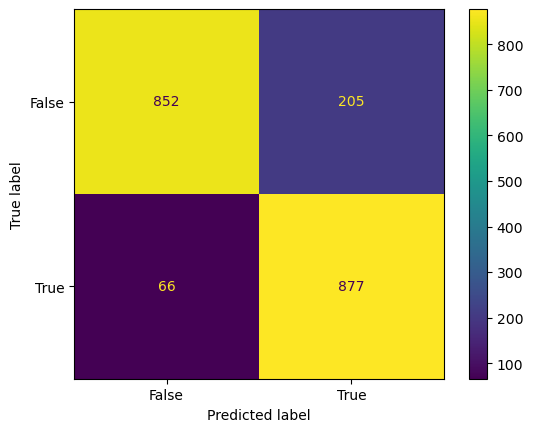

In [35]:
clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

Si nous avons constaté une très faible baisse de notre score en se limitant à un plus faible nombre de variable, il est ici frappant de constater que les prédictions de notre modèle sont excéssivement proches de celles que nous avions sans nous restreindre sur le nombre de modalités. Notons que notre biais semble aussi très similaire.

### Utilisation du modèle logistique avec sélection de variable sur la base entière de 2019
![Confusion_Matrix_2019](Results/Selection/Confusion_Matrix_2019.png "Matrice de confusion Test 2019")

En procédant de facçon symétrique à ce que nous avons fait auparavant, nous pouvons constater que là encore, le fait d'auster notre modèle sur l'ensemble de la base ne change que très peu le résultat, le score restant de 0,865 soit 86,5% de précision, avec un biais vers l'emploi très semblable à ce que nous avions précédemment.

### Utilisation du modèle logistique avec sélection de variable pour prédire en 2020
![Confusion_Matrix_2020](Results/Selection/Confusion_Matrix_2020_fit_2019.png "Matrice de confusion 2020")

De la même façon, nous constatons des performances très proche en procédant à l'ajustement sur l'ensemble de la base 2019 pour prédire la situation d'emploi en 2020, le score ne descendant qu'à 0,862 soit 86,2% de précision, et une légère accentuation de notre biais.

Ainsi, il apparait très clairement que nous pouvons fortement limiter le nombre de variables conservées tout en maintenant une précision très correcte au regarde de notre problème. Le gain en temps de calcul semble ici très largement suffisant pour accepter une si faible perte de précision. (voir  le document "Script_III_D.py" pour le code ayant permi d'obtenir ces matrices de confusion).

Intéressons nous désormais aux variables (ou, plus précisément, aux modalités), conservées par notre modèle.

In [36]:
#Identify the indices of the variables used for prediction in X_transform
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]

X_transform_useful_variables = X_transform[:,variables_indices]

# X_transform n'a pas les meme indices pour les colonnes que X ou EEC_2019 -> Je verifie quelle colonne a les meme 
# valeurs
for j in range(X_transform_useful_variables.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_useful_variables[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column  is equal to the {column_name} column in EEC_2019_subsample")

The 1 column  is equal to the AGE5_60 column in EEC_2019_subsample
The 2 column  is equal to the PCS_0.0 column in EEC_2019_subsample
The 3 column  is equal to the PCS_13.0 column in EEC_2019_subsample
The 4 column  is equal to the PCS_33.0 column in EEC_2019_subsample
The 5 column  is equal to the DIP11_10.0 column in EEC_2019_subsample
The 6 column  is equal to the DIP11_11.0 column in EEC_2019_subsample
The 7 column  is equal to the DIP11_31.0 column in EEC_2019_subsample
The 8 column  is equal to the DIP11_60.0 column in EEC_2019_subsample
The 9 column  is equal to the DIP11_70.0 column in EEC_2019_subsample
The 10 column  is equal to the COUPLE column in EEC_2019_subsample


Il est ici intéressant de s'arrêter sur les variables conservées par le modèle. Tout d'abord, il se contente de ne conserver qu'une seule indicatrice, pour les plus de 60 ans, qui lui permet sans doute d'isoler les personnes retraitées, donc une part importante des inactifs.
Ensuite, peu de PCS sont conservées, mais probablement très significatives : la PCS non renseignée (dont on peut supposer qu'elle isole des individus difficile à atteindre, donc potentiellement moins intégrés au marché du travail), ainsi que deux professions pour lesquels l'emploi s'apparente à un statut, avec un risque de chômage très faible et peu suscpetibles de connaître des périodes d'inactivité : les cadres de la fonction publiques et les agriculteurs sur grande exploitation.
Une série de variable concernant le niveau de diplôme est ensuite conservé, associés à des niveau d'études élevés (niveau licence ou plus pour "10" et "11", des diplômes professionalisant du superieur court ("31" : BTS, DUT)) qu'on peut supposer très favorable à l'insertion professionnelle, et à contrario des niveaux très faibles ("60" : brevet des collèges et "70" : certificat d'études primaires) que l'on va retrouver ches des individus peu insérés sur le marché du travail, soit plus agées (en particulier le CEP) ou ayant fait des choix de vie autre, peut-être dans le cadre d'une spécialisation au sein du couple, l'individu le moins doté scolairement étant plus susceptible de ne pas travailler et de prendre en charge les taches ménagéres, sa participation au marché du travail étant dès lors moins rentable que celle de son conjoint. Cette interprétation est d'ailleurs soutenu par la présence de la variable indicatrice de la situation de vie en couple.

De façon assez intéressante, on remarque donc que ces variables ont été préférées à d'autre, en particulier le sexe (dont on pouvait supposer que son effet sur l'inactivité puisse être important en raison du maintien, certe limité, de certains rôles sexués au sein du couple) ou aux autres actégories d'âges, en particulier les plus jeunes. Il est probable que ces informations puissent être partiellement obtenues par recoupement des autres variables conservées.

## E - Prediction actifs/inactifs

Comme nous l'avons plus à plusieurs reprises, nos prédicteurs ont tendance à avoir un "biais vers l'emploi", c'est à dire à prédire des situations d'emploi pour des individus qui ne sont pas en emploi. Il est probable que cela vienne de la distinction difficile à faire entre chômeurs (en particulier de courte durée) et actifs occupés. Afin de vérifier cela,  nous construisons donc un prédicteur du fait d'être actif sur le même modèle et comparons la qualité de la prediction (en particulier, nous nous attendons à un biais inverse ce coup-ci, si nous avons raison dans notre interprétation).


In [37]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

(10000,)


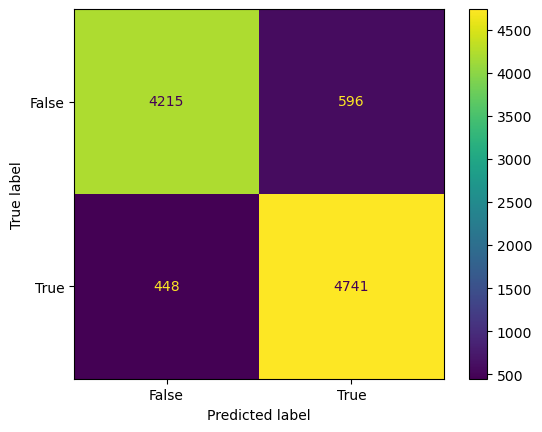

In [38]:
#on teste notre prédicteur d'emploi sur le statut d'activité

y_pred = clf.predict(X_transform)

cm= confusion_matrix(y_bis,y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

Nous remarquons immédiatement que notre prédicteur précédent est en réalité déjà assez efficace pour prédire l'activité (alors qu'il est censée prédire l'emploi). Mais ces deux catégories se recouvrent largement (les chômeurs représentant la différence), le résultat n'est donc pas surprenant. On remarque d'ailleurs que notre biais semble disparaître ici.

Nous renouvelons ensuite le même procédé que pour la partie III D mais cette fois-ci avec notre nouvelle variable d'intérêt.

(10000, 10)
Number of variables considered: 6
0.896


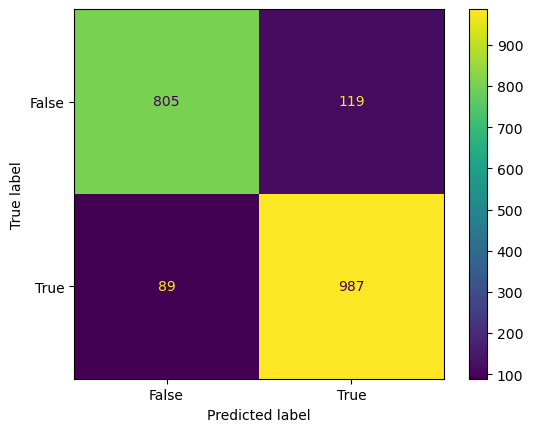

In [40]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
print(gs.score(X_test_2, y_test_2))

Il faut tout d'abord noter que si nous donnons à notre modèle un nombre maximum de modalités à conservées de 10, celui-ci ne donne des coefficients significativement différents de 0 à seulement 6 d'entre eux, semblant indiquer que le modèle pourrit être encore plus parcimonieux. Surtout, nous constatons une légère hausse de notre score, à 0,896 soit 89,6% de bonnes prédictions. Certes, nous retrouvons à nouveau plus de faut positifs que defaux négatifs, mais cet écart est largement réduit. Ces élméments penchent donc en faveur de notre interprétation, selon laquelle la classification des chômeurs, en particulier de courte durée, étaient particulièrement difficile. 

### Utilisation du modèle logistique avec sélection de variable de prévision de l'activité sur la base entière de 2019
![Confusion_Matrix_2019](Results/Actif/Confusion_Matrix_2019.png "Matrice de confusion Test 2019")

Lorsque l'on considère l'ensemble de la base pour 2019, nous conservons un taux de bonne prédictions de 89,0%, et un biais de prédiction très contenu, ce qui confirme nos intuitions.

### Utilisation du modèle logistique avec sélection de variable de prévision de l'activité pour prédire en 2020
![Confusion_Matrix_2020](Results/Actif/Confusion_Matrix_2020_fit_2019.png "Matrice de confusion 2020")

De même, si l'on s'intéresse aux données de 2020, nous conservons 88,5% de bonnes prédictions, et là encore des erreurs de prédictions bien moins biaisées vers les faux positifs.

Il ressort de cette analyse de la prédiction du statut d'catif que celui-ci semble légérement plus simple à prédire, ce qui laisse entendre que les caractéristiques socio-démographiques des chômeurs, probablement en particulier des chômeurs de courte durée, les rapprochent plus des actifs occupés que des inactifs.

In [42]:
#Identify the indices of the variables used for prediction in X_transform
# Iterate over a range of columns in X_transform_bis
for j in range(X_transform_bis.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_bis[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column in X_transform_bis is equal to the {column_name} column in EEC_2019_subsample")

The 1 column in X_transform_bis is equal to the AGE5_60 column in EEC_2019_subsample
The 2 column in X_transform_bis is equal to the PCS_0.0 column in EEC_2019_subsample
The 3 column in X_transform_bis is equal to the PCS_31.0 column in EEC_2019_subsample
The 4 column in X_transform_bis is equal to the DIP11_10.0 column in EEC_2019_subsample
The 5 column in X_transform_bis is equal to the DIP11_11.0 column in EEC_2019_subsample
The 6 column in X_transform_bis is equal to the DIP11_31.0 column in EEC_2019_subsample
The 7 column in X_transform_bis is equal to the DIP11_60.0 column in EEC_2019_subsample
The 8 column in X_transform_bis is equal to the DIP11_70.0 column in EEC_2019_subsample
The 9 column in X_transform_bis is equal to the TYPMEN7_3 column in EEC_2019_subsample
The 10 column in X_transform_bis is equal to the COUPLE column in EEC_2019_subsample


Le choix des variables conservées est assez proche de ce que nous avions pour la prédiction du statut d'emploi. Nous pouvons néanmoins constater que moins de PCS sont prises en comptes, et pas les même (professions libérales et non renseignées), ceci afin de prendre une modalité supplémentaire du niveau de diplôme (DEUG) ainsi qu'une indicatrice pour les couples sans enfant. De fait, ces changements (en particulier au regard des PCS) s'explique par le fait qu'il s'agit moins désormais d'isoler des individus à l'emploi relativement protégé mais plutôt à isoler des situations qui diminuent les passages de l'activité à l'inactivité.